# Algoritmos evolucionários

## O que são?

Os algoritmos evolucionários buscam reproduzir o conceito de evolução humana, onde um indivíduo tende a manter um conjunto de características de uma população anterior e melhorar outras características.

## Algoritmo genético

Dentro dos algoritmos evolucionários temos o conceito de algoritmo genético. Os algoritmos genéticos tentam reproduzir o comportamento genético humano. Dada uma população de N indivíduos, e uma tarefa T, os indivíduos que mais se aproximarem de concluir a tarefa T serão considerados os melhores da espécie e assim são utilizados para reprodução. Após o cruzamento de indivíduos surge uma nova população que é testada e rankeada novamente. Esse processo continua até que sejam encontrados indivíduos considerados "ótimos" para tal tarefa.

A reprodução consiste na permutação de genes entre dois indivíduos, gerando assim um novo. Os novos indivíduos são submetidos a uma mutação, empregada para aumentar a variabilidade genética e impedir que as informações genéticas se estacionem.

Em uma abordagem na área de busca hiperparamétrica os indivíduos (ou cromossomos) são espaços hiperparamétricos e cada gene é um hiperparâmetro (Evolutionary algorithms for hyperparameter optimization in machine learning for application in high energy physics pág 3) e a cada permutação surge um novo cromossomo com uma combinação de hiperparâmetros de cada um dos pais.

Para executar a otimização através de um algoritmo genético será utilizada a evolução diferencial implementada na biblioteca scipy

In [15]:
# importando dependências
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.metrics import r2_score    
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tpot import TPOTRegressor as TPR

C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [5]:
#Recolhendo dados do facebook e preparando dataset

import pandas_datareader.data as web
import datetime as dt

end = dt.datetime(2020, 6, 1)
start = dt.datetime(2019, 1, 1)

df = web.DataReader("FB", 'yahoo', start, end)

df = df.reset_index()
df = df.drop(columns=['Open','Date','High','Low','Volume','Adj Close'])
df = df.rename(columns={'Close': 'Close 0'})

def window (df, w):
    for i in range(1,w):
        df['Close '+str(i)] = df['Close '+str(i-1)].shift(1)
    return df
        
df = window(df,5)
df = df.rename(columns={'Close 0': 'Target'})
df.dropna(inplace=True)
df.head()

,Target,Close 1,Close 2,Close 3,Close 4
4,142.529999,138.050003,137.949997,131.740005,135.679993
5,144.229996,142.529999,138.050003,137.949997,131.740005
6,144.199997,144.229996,142.529999,138.050003,137.949997
7,143.800003,144.199997,144.229996,142.529999,138.050003
8,145.389999,143.800003,144.199997,144.229996,142.529999


In [6]:
#Separando dados de treino e teste
X = df.loc[:, ['Close 1','Close 2','Close 3','Close 4']]
y = df.loc[:, 'Target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

##### Modelos Padrão

In [41]:
# configuração default para knn
# n_neighbors = 5, weights = uniform, algorithm = auto, leaf_size = 30, p=2, metric=minkowski, metric_params=None, n_jobs=None
knn_default = KNR()

# configuração default para decision tree
# criterion=mse, splitter=best, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
# min_weight_fraction_leaf = 0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0
dt_default = DecisionTreeRegressor()

#GradientBoosting
# loss = 'ls', learning_rate = 0.1, n_estimators=100, subsample = 1.0, criterion = 'friedman_mse', 
# max_features = 'auto', alpha = 0.9
gdb_default = GradientBoostingRegressor()

##### Lista de hiperparâmetros

In [49]:
knn_config = {'sklearn.neighbors.KNeighborsRegressor' :{
        'n_neighbors':[3,5,9,11], 
        'weights': ['uniform','distance'], 
        'algorithm':['auto', 'ball_tree', 'brute'], 
        'p':[1,2]
}}

dt_config = {'sklearn.tree.DecisionTreeRegressor':{
    'criterion': ['mse','friedman_mse','mae'], 
    'splitter':['best','random'],
    'min_samples_split':[2,5,10,15],
    'max_features':['auto','sqrt','log2']
}}

gdb_config = {'sklearn.ensemble.GradientBoostingRegressor':{
    'loss':['ls','lad','huber','quantile'], 
    'learning_rate':[0.05,0.1,0.2,0.3,0.5,0.75],
    'n_estimators':[15,30,50,100,150,300,500],
    'subsample':[0.3,0.5,0.7,0.9,1.0], 
    'criterion': ['friedman_mse','mse','mae'], 
    'max_features':['auto','sqrt','log2'],
    'alpha':[0.05,0.1,0.3,0.5,0.75,0.9, 0.99]
}}

##### Criando modelos ajustados

In [93]:
knn_tpot = TPR(generations= 5, population_size= 30, random_state=1, config_dict=knn_config, cv= 5, verbosity = 2)

dt_tpot = TPR(generations= 5, population_size= 30, random_state=1, config_dict=dt_config, cv= 5, verbosity = 2)

gdb_tpot = TPR(generations= 5, population_size= 30, random_state=1, config_dict=gdb_config, cv= 5, verbosity = 2)

In [94]:
# Ajustando modelos treinados
knn_default.fit(X_train, y_train)

knn_i = time.time()

knn_tpot.fit(X_train, y_train)

knn_f = time.time()


Generation 1 - Current best internal CV score: -22.96571432441449

Generation 2 - Current best internal CV score: -22.96571432441449

Generation 3 - Current best internal CV score: -22.96571432441449

Generation 4 - Current best internal CV score: -22.96571432441449

Generation 5 - Current best internal CV score: -22.96571432441449

Best pipeline: KNeighborsRegressor(KNeighborsRegressor(input_matrix, algorithm=brute, n_neighbors=5, p=2, weights=uniform), algorithm=brute, n_neighbors=5, p=1, weights=uniform)


In [95]:
dt_default.fit(X_train, y_train)

dt_i = time.time()

dt_tpot.fit(X_train, y_train)

dt_f = time.time()


Generation 1 - Current best internal CV score: -27.288334875667793

Generation 2 - Current best internal CV score: -27.288334875667793

Generation 3 - Current best internal CV score: -26.8494607276455

Generation 4 - Current best internal CV score: -26.8494607276455

Generation 5 - Current best internal CV score: -24.58505737335349

Best pipeline: DecisionTreeRegressor(CombineDFs(input_matrix, CombineDFs(input_matrix, CombineDFs(input_matrix, CombineDFs(input_matrix, input_matrix)))), criterion=friedman_mse, max_features=auto, min_samples_split=10, splitter=random)


In [96]:
gdb_default.fit(X_train, y_train)

gdb_i = time.time()

gdb_tpot.fit(X_train, y_train)

gdb_f = time.time()


Generation 1 - Current best internal CV score: -20.790071080329586

Generation 2 - Current best internal CV score: -20.295313401724524

Generation 3 - Current best internal CV score: -20.295313401724524

Generation 4 - Current best internal CV score: -20.295313401724524

Generation 5 - Current best internal CV score: -20.075515495346004

Best pipeline: GradientBoostingRegressor(CombineDFs(input_matrix, CombineDFs(input_matrix, input_matrix)), alpha=0.1, criterion=mae, learning_rate=0.1, loss=ls, max_features=auto, n_estimators=50, subsample=0.5)


##### Criando modelos ajustados

In [110]:
#Podem ser utilizados esses modelos ou os modelos já treinados modelo_tpot

knn_tuned = KNR(algorithm='brute', n_neighbors=5, p=1, weights='uniform')

dt_tuned = DecisionTreeRegressor(criterion='friedman_mse', max_features='auto', min_samples_split=10, splitter='random', random_state=10)

gdb_tuned = GradientBoostingRegressor(alpha=0.1, criterion='mae', learning_rate=0.1, loss='ls', max_features='auto', n_estimators=50, subsample=0.5, random_state=10)

In [97]:
# Função para calcular pontuação r^2 dos modelos ajustados
def calculate_r2(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    return r2

In [111]:
#Recolhendo pontuações dos modelos padrão

knn_default_score = knn_default.score(X_test, y_test)
dt_default_score = dt_default.score(X_test, y_test)
gdb_default_score = gdb_default.score(X_test, y_test)

#Recolhendo predições dos modelos padrão

knn_default_pred = knn_default.predict(X_test)
dt_default_pred = dt_default.predict(X_test)
gdb_default_pred = gdb_default.predict(X_test)

In [115]:
#Treinando modelos ajustados

knn_tuned.fit(X_train, y_train)
dt_tuned.fit(X_train, y_train)
gdb_tuned.fit(X_train, y_train)

#Recolhendo pontuações dos modelos ajustados

knn_tuned_score = knn_tuned.score(X_test, y_test)
dt_tuned_score = dt_tuned.score(X_test, y_test)
gdb_tuned_score = gdb_tuned.score(X_test, y_test)

#Recolhendo predições dos modelos ajustados

knn_tuned_pred = knn_tuned.predict(X_test)
dt_tuned_pred = dt_tuned.predict(X_test)
gdb_tuned_pred = gdb_tuned.predict(X_test)

#Para usar os modelos gerados automaticamente usar as linhas abaixo

#Recolhendo predições e pontuações dos modelos ajustados
#A pontuação gerada pelo método TPOTRegressor é neg_mean_absolute_error, então, para manter a mesma pontuação dos outros modelos
#será usada a função calcular_r2 para calcular a pontuação dos modelos ajustados

#knn_tpot_pred = knn_tpot.predict(X_test);
#dt_tpot_pred = dt_tpot.predict(X_test);
#gdb_tpot_pred = gdb_tpot.predict(X_test);

#knn_tpot_score = calculate_r2(y_test, knn_tpot_pred)
#dt_tpot_score = calculate_r2(y_test, dt_tpot_pred)
#gdb_tpot_score = calculate_r2(y_test, gdb_tpot_pred)

In [116]:
print('--RELATÓRIO--')

print('KNN:')
print('Default score: ',knn_default_score)
print('Tuned score: ',knn_tuned_score)
print('Tempo: ',knn_f-knn_i)
print('--------------------')

print('Decision Tree:')
print('Default score: ',dt_default_score)
print('Tuned score: ',dt_tuned_score)
print('Tempo: ',dt_f-dt_i)
print('--------------------')

print('Gradient Boosting:')
print('Default score: ',gdb_default_score)
print('Tuned score: ',gdb_tuned_score)
print('Tempo: ',gdb_f-gdb_i)
print('--------------------')

--RELATÓRIO--
KNN:
Default score:  0.9296488936282796
Tuned score:  0.9310675478439643
Tempo:  20.461069345474243
--------------------
Decision Tree:
Default score:  0.9006796856879037
Tuned score:  0.9307222163082389
Tempo:  15.737758874893188
--------------------
Gradient Boosting:
Default score:  0.9444213797666712
Tuned score:  0.9452447912000138
Tempo:  766.477231502533
--------------------


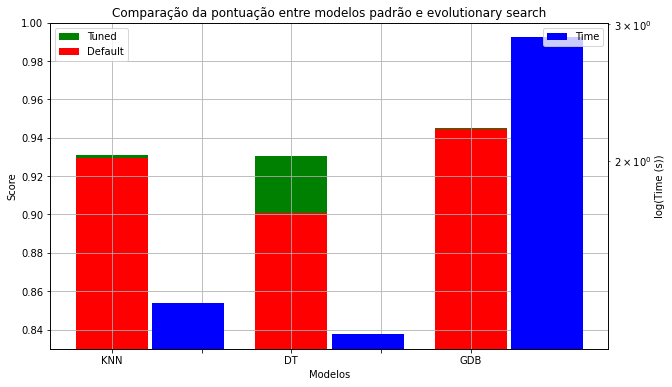

In [121]:
#Visualizando resultados

#plt.figure(figsize=(10,6))
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(0, knn_tuned_score, color='green', label='Tuned')
ax1.bar(0, knn_default_score, color='red', label='Default')

ax1.bar(2, dt_tuned_score, color='green')
ax1.bar(2, dt_default_score, color='red')

ax1.bar(4, gdb_tuned_score, color='green')
ax1.bar(4, gdb_default_score, color='red')

ax1.set_ylim(0.83, 1.0)
ax1.set_ylabel('Score')
ax1.set_xlabel('Modelos')
ax1.set_title('Comparação da pontuação entre modelos padrão e evolutionary search')
ax1.legend(loc='upper left')

ax1.grid()

# Plotando tempos
ax2 = ax1.twinx()

ax2.bar(0.85, math.log(knn_f-knn_i,10), color='blue', label='Time')
ax2.bar(2.85, math.log(dt_f-dt_i,10), color='blue')
ax2.bar(4.85, math.log(gdb_f-gdb_i,10), color='blue')
ax2.set_yscale('log')
ax2.set_ylabel('log(Time (s))')
ax2.legend(loc='upper right')


plt.xticks(np.arange(5),['KNN','','DT','','GDB'])
plt.show()